# Retrieve Raw Data From GitHub

In [2]:
import requests
import io
import csv
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler
import random


random.seed(69)
torch.manual_seed(420)


def get_sentences():
    urls = []
    urls.append('https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/trainEncoded')
    urls.append('https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/validEncoded')
    urls.append('https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/testEncoded')
    raws = [requests.get(u).text for u in urls]
    separated = [csv.reader(io.StringIO(r)) for r in raws]
    processed = [[], [], []]
    for i in range(len(separated)):
        for row in separated[i]:
            idxs = row[2][1:-1].split(', ')
            if idxs[0] == '': continue
            idxs = list(map(int, idxs))
            idxs = torch.tensor([i % 10000 for i in idxs])
            label = torch.tensor(int(row[1] == '[76645]')).long()
            processed[i].append((idxs, label))

    return processed[0], processed[1], processed[2]


def get_sentences_2(glove):
    url = 'https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/sms%2Bspam%2Bcollection/SMSSpamCollection'
    separated = csv.reader(io.StringIO(requests.get(url).text), delimiter='\t')
    spam, ham = [], []
    for row in separated:
        sentence = row[1].replace('.', ' . ') \
            .replace(',', ' , ') \
            .replace(';', ' ; ') \
            .replace('?', ' ? ')
        sentence = sentence.lower().split()
        idxs = [glove.stoi[w] for w in sentence if w in glove.stoi]
        if not idxs: continue
        idxs = torch.tensor(idxs)
        label = torch.tensor(int(row[0] == 'spam')).long()
        if label.item() == 1:
            spam.append((idxs, label))
        elif label.item() == 0:
            ham.append((idxs, label))

    train, valid, test = [], [], []
    for i, example in enumerate(spam):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    train = [example for example in train for _ in range(6)]
    for i, example in enumerate(ham):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    return train, valid, test


def get_sentences_3():
    url = 'https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/sms%2Bspam%2Bcollection/SMSSpamCollection'
    separated = csv.reader(io.StringIO(requests.get(url).text), delimiter='\t')
    spam, ham = [], []
    for row in separated:
        if row[1] == '': continue
        label = int(row[0] == 'spam')
        if label == 1:
            spam.append((label, row[1]))
        elif label == 0:
            ham.append((label, row[1]))

    train, valid, test = [], [], []
    for i, example in enumerate(spam):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    train = [example for example in train for _ in range(6)]
    for i, example in enumerate(ham):
        if i % 5 < 3:
            train.append(example)
        elif i % 5 == 3:
            valid.append(example)
        else:
            test.append(example)

    return train, valid, test


def yield_tokens(sentences):
    for _, sentence in sentences:
        yield tokenizer_c(sentence)


def get_vocab(sentences):
    vocab = build_vocab_from_iterator(yield_tokens(sentences),
                                      specials=['<UNK>', '<BOS>', '<EOS>', '<PAD>'],
                                      max_tokens=20000)
    vocab.set_default_index(vocab['<UNK>'])
    return vocab


def collate_batch(batch):
    label_list, word_list, char_list = [], [], []
    for (_label, _sentence) in batch:
          label_list.append(_label)
          word_list.append(torch.tensor(sentence_transform_w(_sentence)))
          char_list.append(torch.tensor(sentence_transform_c(_sentence)))
    word_sequence = pad_sequence(word_list, batch_first=True, padding_value=3.0)
    char_sequence = pad_sequence(char_list, batch_first=True, padding_value=3.0)
    return torch.tensor(label_list), torch.cat((word_sequence,
                                                torch.tensor([-1]).expand(len(batch), 1),
                                                char_sequence), 1)


class BatchSamplerSimilarLength(Sampler):
    def __init__(self, sentences, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = [(i, len(tokenizer_w(s[1])) + len(tokenizer_c(s[1]))) for i, s
                        in enumerate(sentences)]
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()


    def __iter__(self):
        if self.shuffle: random.shuffle(self.indices)
        pooled_indices = []
        for i in range(0, len(self.indices), self.batch_size * 100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100],
                                         key=lambda x: x[1]))

        self.pooled_indices = [x[0] for x in pooled_indices]
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]
        if self.shuffle:
            random.shuffle(batches)

        for batch in batches:
            yield batch


    def __len__(self):
        return len(self.pooled_indices) // self.batch_size

# Batch Data With Similar Length Randomly

In [3]:
class Batcher:
    def __init__(self, sentences, batch_size=32, drop_last=False):
        self.batch_size = batch_size
        self.sentences_by_length = {}
        for sentence, label in sentences:
            len = sentence.size(0)
            if len not in self.sentences_by_length:
                self.sentences_by_length[len] = []

            self.sentences_by_length[len].append((sentence, label))

        self.loaders = {len: torch.utils.data.DataLoader(
                sentences,
                batch_size=batch_size,
                shuffle=True,
                drop_last=drop_last) for len, sentences in self.sentences_by_length.items()}


    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            it = random.choice(iters)
            try:
                yield next(it)

            except StopIteration:
                iters.remove(it)

# Create GRU and LSTM Network Models

In [4]:
import torch.nn as nn


class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(GRUNet, self).__init__()
        self.name = 'GRU'
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x, hidden=None):
        x = self.emb(x)
        out, _ = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out


class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(LSTMNet, self).__init__()
        self.name = 'LSTM'
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x, h0c0=None):
        x = self.emb(x)
        out, _ = self.rnn(x, h0c0)
        out = self.fc(out[:, -1, :])
        return out


class LSTMNet_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(LSTMNet_2, self).__init__()
        self.name = 'LSTM2'
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)


    def forward(self, x, h0c0=None):
        x = self.emb(x)
        out, _ = self.rnn(x, h0c0)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out


class LSTMNet_3(nn.Module):
    def __init__(self, input_size_w, input_size_c, hidden_size_w, hidden_size_c,
                 num_classes, glove, num_layers_w=1, num_layers_c=1):
        super(LSTMNet_3, self).__init__()
        self.name = 'LSTM3'
        self.hidden_size_w = hidden_size_w
        self.hidden_size_c = hidden_size_c
        self.num_layers_w = num_layers_w
        self.num_layers_c = num_layers_c
        pretrained_embeddings = glove.vectors
        pretrained_embeddings = torch.cat((torch.zeros(4, pretrained_embeddings.shape[1]),
                                           pretrained_embeddings))
        self.emb = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.eye = torch.eye(input_size_c)
        if torch.cuda.is_available(): self.eye = torch.eye(input_size_c, device='cuda').cuda()
        self.rnn_w = nn.LSTM(input_size_w, hidden_size_w, num_layers_w, batch_first=True)
        self.rnn_c = nn.LSTM(input_size_c, hidden_size_c, num_layers_c, batch_first=True)
        self.fc = nn.Linear(hidden_size_w + hidden_size_c, num_classes)


    def forward(self, x, h0c0_w=None, h0c0_c=None):
        div = torch.nonzero(x[0].eq(-1))[0, 0].item()
        w = self.emb(x[:, :div])
        c = self.eye[x[:, div + 1:]]
        out_w, _ = self.rnn_w(w, h0c0_w)
        out_c, _ = self.rnn_c(c, h0c0_c)
        length_w = (torch.sum(torch.where(x[:, :div] != 3, 1, 0),
                              dim=1,
                              keepdim=True) - 1).expand(-1, self.hidden_size_w).unsqueeze(1)
        length_c = (torch.sum(torch.where(x[:, div + 1:] != 3, 1, 0),
                              dim=1,
                              keepdim=True) - 1).expand(-1, self.hidden_size_c).unsqueeze(1)
        out_w = out_w.gather(1, length_w).squeeze(1)
        out_c = out_c.gather(1, length_c).squeeze(1)
        out = torch.cat((out_w, out_c), dim=1)
        out = self.fc(out)
        return out

# Evaluate Model Accuracy on Selected Data

In [5]:
def get_accuracy(model, loader):
    correct, total = 0, 0
    for labels, sentences in loader:
        if torch.cuda.is_available():
            sentences = sentences.cuda()
            labels = labels.cuda()

        output = model(sentences)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.size(0)

    return correct / total

# Generate File Path to Save Network Model

In [6]:
def get_file_path(name, glove, batch_size, hidden_size, num_layers, learning_rate):
    path = '{0}_{1}_bs{2}_hs{3}_nl{4}_lr{5}_'.format(name,
                                                     glove,
                                                     batch_size,
                                                     hidden_size,
                                                     num_layers,
                                                     learning_rate)
    return '/content/drive/MyDrive/Colab/' + path

# Train Network Model

In [7]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


def train_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    for epoch in range(num_epochs):
        for labels, sentences in train:
            if torch.cuda.is_available():
                sentences = sentences.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            pred = model(sentences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print('Epoch %d; Loss %f; Train Acc %f; Valid Acc %f' % (epoch,
                                                                 loss,
                                                                 train_acc[-1],
                                                                 valid_acc[-1]))
        path = get_file_path(model.name,
                             'twi50',
                             16,
                             model.hidden_size_w,
                             model.num_layers_w,
                             learning_rate)
        torch.save(model.state_dict(), path + str(epoch))

    np.savetxt('{}losses.csv'.format(path), losses)
    np.savetxt('{}train.csv'.format(path), train_acc)
    np.savetxt('{}valid.csv'.format(path), valid_acc)

    plt.title('Loss Curve')
    plt.plot(losses, label='Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.title('Accuracy Curve')
    plt.plot(train_acc, label='Training')
    plt.plot(valid_acc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

# Evaluate Network Model

In [8]:
def get_scores(model, loader):
    tp, tn, fp, fn = 0, 0, 0, 0
    for labels, sentences in loader:
        if torch.cuda.is_available():
            sentences = sentences.cuda()
            labels = labels.cuda()

        output = model(sentences)
        pred = output.max(1, keepdim=True)[1]
        results = pred * 2 + labels.view_as(pred)
        tp += results.eq(3).sum().item()
        tn += results.eq(0).sum().item()
        fp += results.eq(2).sum().item()
        fn += results.eq(1).sum().item()

    print('TP', tp, 'TN', tn, 'FP', fp, 'FN', fn)
    print('False Positive Rate', fp / (fp + tn))
    print('False Negative Rate', fn / (fn + tp))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    print('Recall', recall)
    print('Precision', precision)
    print('F1 Score', 2 * recall * precision / (recall + precision))

# Plot Training Curves of Selected Network Model

In [9]:
def plot_training_curves(path):
    losses = np.loadtxt('{}losses.csv'.format(path))
    train_acc = np.loadtxt('{}train.csv'.format(path))
    valid_acc = np.loadtxt('{}valid.csv'.format(path))

    plt.title('Loss Curve')
    plt.plot(losses, label='Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.title('Accuracy Curve')
    plt.plot(train_acc, label='Training')
    plt.plot(valid_acc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

# Detect Spam on Sample SMS Message

In [10]:
import torch.nn.functional as F


def evaluate_sample(sample, model, glove):
    sentence = sample.replace('.', ' . ') \
        .replace(',', ' , ') \
        .replace(';', ' ; ') \
        .replace('?', ' ? ')
    sentence = sentence.lower().split()
    idxs = torch.tensor([glove.stoi[w] for w in sentence if w in glove.stoi])
    if torch.cuda.is_available(): idxs = idxs.cuda()
    pred = model(idxs.unsqueeze(0))
    pred = F.softmax(pred, dim=1)[0, 1].item()
    print(sample)
    print('Probability of Spam', pred)


def evaluate_sample_2(sample, model, transform_w, transform_c):
    idxs = torch.tensor(sentence_transform_w(sample) + [-1] + sentence_transform_c(sample))
    if torch.cuda.is_available(): idxs = idxs.cuda()
    pred = model(idxs.unsqueeze(0))
    pred = F.softmax(pred, dim=1)[0, 1].item()
    print(sample)
    print('Probability of Spam', pred)

# Create Objects and Run Functions

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader


!nvidia-smi

random.seed(69)
torch.manual_seed(420)

train, valid, test = get_sentences_3()

tokenizer_w = get_tokenizer('basic_english')
tokenizer_c = get_tokenizer(lambda x: list(x))

glove_vectors = torchtext.vocab.GloVe(name='twitter.27B', dim=50)
vocab_w = torchtext.vocab.vocab(glove_vectors.stoi)
vocab_w.insert_token('<UNK>', 0)
vocab_w.insert_token('<BOS>', 1)
vocab_w.insert_token('<EOS>', 2)
vocab_w.insert_token('<PAD>', 3)
vocab_w.set_default_index(0)
vocab_c = get_vocab(train)

sentence_transform_w = lambda x: [vocab_w['<BOS>']] + [vocab_w[token] for token in
                                                       tokenizer_w(x)] + [vocab_w['<EOS>']]
sentence_transform_c = lambda x: [vocab_c['<BOS>']] + [vocab_c[token] for token in
                                                       tokenizer_c(x)] + [vocab_c['<EOS>']]

train_loader = DataLoader(train, batch_sampler=BatchSamplerSimilarLength(
    sentences=train,
    batch_size=16), collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_sampler=BatchSamplerSimilarLength(
    sentences=valid,
    batch_size=16), collate_fn=collate_batch)
test_loader = DataLoader(test, batch_sampler=BatchSamplerSimilarLength(
    sentences=test,
    batch_size=16), collate_fn=collate_batch)

Wed Apr  3 08:45:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              29W /  70W |   1141MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

CUDA is available! Training on GPU...
Epoch 0; Loss 0.186115; Train Acc 0.573985; Valid Acc 0.291741
Epoch 1; Loss 0.101268; Train Acc 0.928789; Valid Acc 0.954219
Epoch 2; Loss 0.119836; Train Acc 0.939524; Valid Acc 0.963196
Epoch 3; Loss 0.059311; Train Acc 0.949544; Valid Acc 0.962298
Epoch 4; Loss 0.143440; Train Acc 0.962426; Valid Acc 0.962298
Epoch 5; Loss 0.029518; Train Acc 0.966362; Valid Acc 0.962298
Epoch 6; Loss 0.008374; Train Acc 0.968688; Valid Acc 0.965889
Epoch 7; Loss 0.354912; Train Acc 0.976382; Valid Acc 0.965889
Epoch 8; Loss 0.013593; Train Acc 0.980855; Valid Acc 0.967684
Epoch 9; Loss 0.016723; Train Acc 0.984792; Valid Acc 0.973968
Epoch 10; Loss 0.008745; Train Acc 0.943818; Valid Acc 0.976661
Epoch 11; Loss 0.010422; Train Acc 0.982466; Valid Acc 0.976661
Epoch 12; Loss 0.005383; Train Acc 0.991412; Valid Acc 0.976661
Epoch 13; Loss 0.008342; Train Acc 0.993559; Valid Acc 0.977558
Epoch 14; Loss 0.027050; Train Acc 0.993201; Valid Acc 0.977558
Epoch 15; Lo

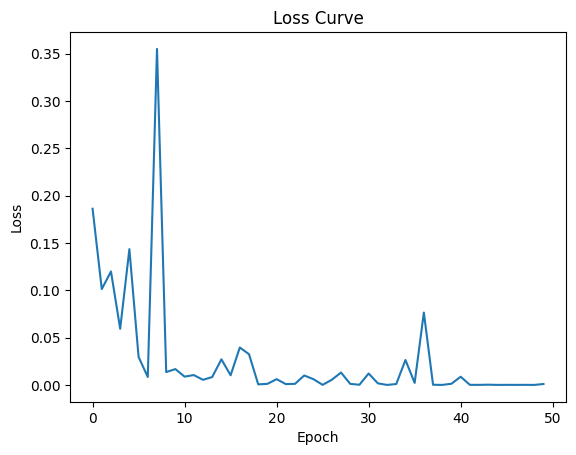

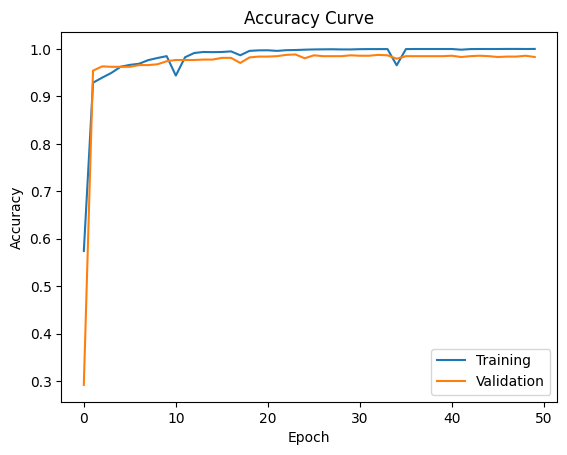

TP 136 TN 959 FP 6 FN 13
False Positive Rate 0.0062176165803108805
False Negative Rate 0.087248322147651
Recall 0.912751677852349
Precision 0.9577464788732394
F1 Score 0.9347079037800687
Total Number of Parameters 59759534


In [14]:
random.seed(69)
torch.manual_seed(420)


model = LSTMNet_3(50, len(vocab_c), 25, len(vocab_c) // 2,
                  2, glove_vectors, num_layers_w=2, num_layers_c=2)
if torch.cuda.is_available():
    model.cuda()
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=2e-4)

get_scores(model, valid_loader)

size = 0
for param in model.parameters():
    size += torch.numel(param)
print('Total Number of Parameters', size)

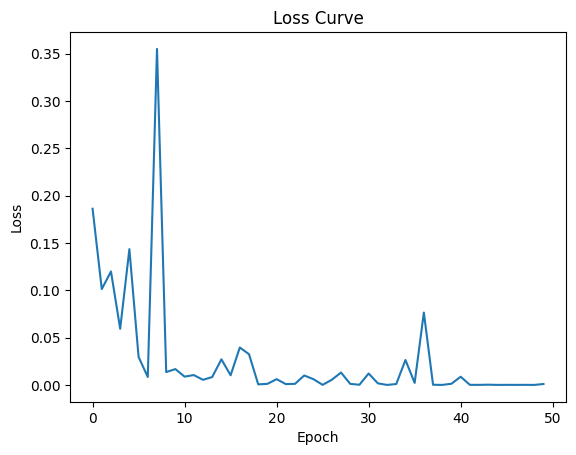

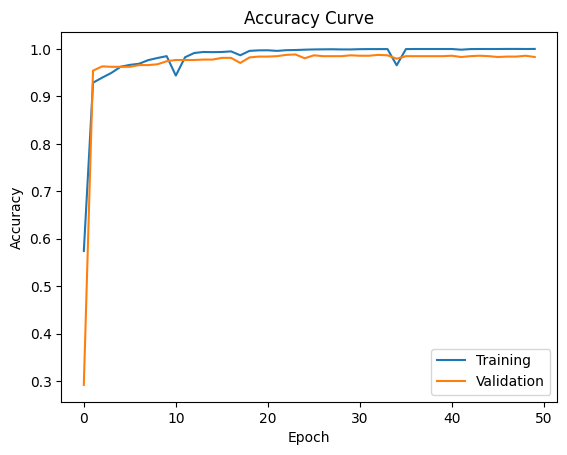

Test Accuracy 0.9793536804308797
TP 140 TN 961 FP 4 FN 9
False Positive Rate 0.004145077720207254
False Negative Rate 0.06040268456375839
Recall 0.9395973154362416
Precision 0.9722222222222222
F1 Score 0.9556313993174061
But let's just say it involves whipped cream and whipped cream
Probability of Spam 0.001395990140736103
Congratulations! You've won a $1,000 Walmart gift card. Go to https://bit.ly/123456 to claim now.
Probability of Spam 0.9999388456344604


In [27]:
tuned_model = LSTMNet_3(50, len(vocab_c), 25, len(vocab_c) // 2,
                  2, glove_vectors, num_layers_w=2, num_layers_c=2)
if torch.cuda.is_available(): tuned_model.cuda()
path = get_file_path('LSTM3', 'twi50', 16, 25, 2, 2e-4)
tuned_model.load_state_dict(torch.load(path + '23'))

plot_training_curves(path)

print('Test Accuracy', get_accuracy(tuned_model, test_loader))

get_scores(tuned_model, valid_loader)

evaluate_sample_2('But let\'s just say it involves whipped cream and whipped cream',
                tuned_model, sentence_transform_w, sentence_transform_c)
evaluate_sample_2('Congratulations! You\'ve won a $1,000 Walmart gift card. Go to https://bit.ly/123456 to claim now.',
                tuned_model, sentence_transform_w, sentence_transform_c)